# LangGraph로 구현하는 Self-Correcting RAG 시스템

이번 실습에서는 LangGraph를 활용하여 스스로 품질을 검증하고 개선하는 고급 RAG 시스템을 만듭니다.  
각 단계마다 품질을 체크하고, 문제가 있으면 자동으로 수정하는 시스템입니다!

## 0. 환경 설정
  
### 필요한 라이브러리 설치


```
pip install langgraph langchain langchain-openai langchain-community chromadb openai python-dotenv
```

### 라이브러리 Import

In [4]:
import os
import json
from dotenv import load_dotenv
from typing import TypedDict, Literal

# LangChain 관련
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_community.vectorstores import Chroma
from langchain.schema import Document

# LangGraph 관련
from langgraph.graph import StateGraph, END

# 환경 변수 로드
load_dotenv()

print("✅ 환경 설정 완료!")

✅ 환경 설정 완료!


## 1. Self-Correcting RAG 개요

### 일반 RAG vs Self-Correcting RAG

#### 일반 RAG (3강):

```
질문 → 검색 → 답변 생성 → 끝
```

#### Self-Correcting RAG (4강):

```
질문 → 질문 평가 → ❌ → 질문 재작성 → 다시 평가
         ↓ ✅
       검색 → 검색 평가 → ❌ → 쿼리 재작성 → 다시 검색
         ↓ ✅
     답변 생성 → 답변 평가 → ❌ → 문제 진단 → 해당 단계 복귀
         ↓ ✅
       최종 답변
```

#### 일반 RAG의 한계:

1. **부정확한 검색**
   - 문제: "우리 회사 휴가 정책은?" → 근무시간 문서 검색됨
   - 원인: 질문이 모호하거나 임베딩 매칭 실패
   - 결과: 잘못된 문서 기반 답변

2. **관련 없는 문서 검색**
   - 문제: 질문과 무관한 문서가 상위 검색됨
   - 원인: 키워드는 유사하지만 맥락이 다름
   - 결과: "문서에서 찾을 수 없습니다" (있는데도!)

3. **불완전한 답변**
   - 문제: 검색은 잘 됐는데 답변이 부정확
   - 원인: LLM이 문서를 잘못 해석하거나 환각(Hallucination)
   - 결과: 신뢰할 수 없는 답변

4. **컨텍스트 부족**
   - 문제: 여러 문서를 조합해야 하는 질문
   - 원인: Top-K 검색으로 중요한 문서 누락
   - 결과: 불완전한 답변

#### Self-Correcting RAG의 해결책:

✅ **자동 검증 및 재시도**
- 각 단계마다 품질 검증
- 실패 시 자동으로 재시도
- 최적의 결과 도출

✅ **적응형 검색**
- 검색 실패 시 쿼리 재작성
- 다양한 검색 전략 시도
- 관련성 점수 기반 필터링

✅ **답변 검증**
- 생성된 답변의 정확성 평가
- 문서와의 일치도 확인
- 환각 방지


## 2. 데이터 준비
   
### 벡터 스토어 로드

In [5]:
# JSON 파일에서 데이터 로드
with open('company_info.json', 'r', encoding='utf-8') as f:
    company_data = json.load(f)

# Document 객체로 변환
documents = []
for item in company_data:
    doc = Document(
        page_content=f"주제: {item['topic']}\n내용: {item['content']}",
        metadata={"id": item["id"], "topic": item["topic"]}
    )
    documents.append(doc)

# 임베딩 및 벡터 스토어
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

vectorstore = Chroma(
    persist_directory="./chroma_db",
    embedding_function=embeddings,
    collection_name="company_info"
)

retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 3})

# LLM 초기화
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.7)

print(f"✅ 준비 완료! 문서 수: {vectorstore._collection.count()}")

/var/folders/v0/pvjcwqc95gj2jn9n12jxcqz80000gn/T/ipykernel_83021/480004461.py:17: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vectorstore = Chroma(


✅ 준비 완료! 문서 수: 0


## 3. State 정의

### Self-Correcting RAG의 모든 상태를 관리하는 State를 정의합니다.

In [6]:
class SelfCorrectingRAGState(TypedDict):
    """Self-Correcting RAG 워크플로우 상태"""
    # 입력
    original_question: str  # 원본 질문
    
    # 질문 처리
    current_question: str  # 현재 처리 중인 질문 (재작성될 수 있음)
    question_quality: str  # "good" or "bad"
    question_rewrite_count: int  # 질문 재작성 횟수
    
    # 검색 처리
    search_query: str  # 검색 쿼리
    retrieved_docs: list  # 검색된 문서들
    retrieval_quality: str  # "relevant" or "irrelevant"
    search_retry_count: int  # 검색 재시도 횟수
    
    # 답변 처리
    answer: str  # 생성된 답변
    answer_quality: str  # "good" or "bad"
    problem_diagnosis: str  # 문제 진단 결과
    
    # 제어
    max_retries: int  # 최대 재시도 횟수

## 4. 노드 함수 구현

### Step 1: 질문 평가 노드

In [7]:
def evaluate_question(state: SelfCorrectingRAGState) -> SelfCorrectingRAGState:
    """
    질문이 명확하고 구체적인지 평가합니다.
    """
    question = state["current_question"]
    
    evaluation_prompt = f"""
다음 질문이 명확하고 구체적인지 평가해주세요.

질문: "{question}"

평가 기준:
1. 질문이 무엇을 묻는지 명확한가?
2. 문맥 없이도 이해 가능한가?
3. 회사 정보에 대한 질문인가?

"good" 또는 "bad" 중 하나로만 답변하세요.
""".strip()
    
    response = llm.invoke(evaluation_prompt)
    quality = response.content.strip().lower()
    
    # "good"이나 "bad"가 포함되어 있는지 확인
    if "good" in quality:
        quality = "good"
    else:
        quality = "bad"
    
    print(f"🔍 [질문 평가] {question}")
    print(f"   결과: {quality}")
    
    return {
        **state,
        "question_quality": quality
    }

### Step 2: 질문 재작성 노드

In [8]:
def rewrite_question(state: SelfCorrectingRAGState) -> SelfCorrectingRAGState:
    """
    질문을 더 명확하고 구체적으로 재작성합니다.
    """
    question = state["current_question"]
    
    rewrite_prompt = f"""다음 질문을 더 명확하고 구체적으로 재작성해주세요.

원본 질문: "{question}"

재작성 시 고려사항:
1. 회사 정보를 묻는 것이 명확하게 드러나도록
2. 애매한 표현 제거
3. 구체적인 정보 요청으로 변환

재작성된 질문만 답변하세요.
"""
    
    response = llm.invoke(rewrite_prompt)
    rewritten = response.content.strip()
    
    print(f"✏️  [질문 재작성]")
    print(f"   원본: {question}")
    print(f"   재작성: {rewritten}")
    
    return {
        **state,
        "current_question": rewritten,
        "question_rewrite_count": state.get("question_rewrite_count", 0) + 1
    }

### Step 3: 문서 검색 노드

In [9]:
def retrieve_documents(state: SelfCorrectingRAGState) -> SelfCorrectingRAGState:
    """
    벡터 DB에서 관련 문서를 검색합니다.
    """
    # search_query가 있으면 사용, 없으면 current_question 사용
    query = state.get("search_query") or state["current_question"]
    
    docs = retriever.invoke(query)
    
    print(f"📚 [문서 검색] 쿼리: {query}")
    print(f"   검색된 문서 수: {len(docs)}")
    for i, doc in enumerate(docs, 1):
        print(f"   {i}. {doc.metadata.get('topic', 'N/A')}")
    
    return {
        **state,
        "retrieved_docs": docs,
        "search_query": query
    }

### Step 4: 검색 결과 평가 노드

In [10]:
def evaluate_retrieval(state: SelfCorrectingRAGState) -> SelfCorrectingRAGState:
    """
    검색된 문서가 질문과 관련있는지 평가합니다.
    """
    question = state["current_question"]
    docs = state["retrieved_docs"]
    
    # 검색된 문서 내용 결합
    docs_content = "\n\n".join([f"문서 {i+1}: {doc.page_content[:100]}..." 
                                 for i, doc in enumerate(docs)])
    
    evaluation_prompt = f"""다음 질문에 대해 검색된 문서들이 관련성이 있는지 평가해주세요.

질문: "{question}"

검색된 문서들:
{docs_content}

평가 기준:
1. 문서에 질문에 답할 수 있는 정보가 포함되어 있는가?
2. 문서와 질문의 주제가 일치하는가?

"relevant" 또는 "irrelevant" 중 하나로만 답변하세요.
"""
    
    response = llm.invoke(evaluation_prompt)
    quality = response.content.strip().lower()
    
    if "relevant" in quality:
        quality = "relevant"
    else:
        quality = "irrelevant"
    
    print(f"✅ [검색 평가] 결과: {quality}")
    
    return {
        **state,
        "retrieval_quality": quality
    }

### Step 5: 검색 쿼리 재작성 노드

In [11]:
def rewrite_search_query(state: SelfCorrectingRAGState) -> SelfCorrectingRAGState:
    """
    더 나은 검색 결과를 위해 쿼리를 재작성합니다.
    """
    question = state["current_question"]
    previous_query = state.get("search_query", question)
    
    rewrite_prompt = f"""검색 결과가 부적절했습니다. 더 나은 검색 결과를 위해 쿼리를 재작성해주세요.

원본 질문: "{question}"
이전 검색 쿼리: "{previous_query}"

재작성 시 고려사항:
1. 핵심 키워드 강조
2. 동의어나 관련 용어 포함
3. 더 구체적인 표현 사용

재작성된 검색 쿼리만 답변하세요.
"""
    
    response = llm.invoke(rewrite_prompt)
    new_query = response.content.strip()
    
    print(f"🔄 [쿼리 재작성]")
    print(f"   이전: {previous_query}")
    print(f"   재작성: {new_query}")
    
    return {
        **state,
        "search_query": new_query,
        "search_retry_count": state.get("search_retry_count", 0) + 1
    }

### Step 6: 답변 생성 노드

In [12]:
def generate_answer(state: SelfCorrectingRAGState) -> SelfCorrectingRAGState:
    """
    검색된 문서를 바탕으로 답변을 생성합니다.
    """
    question = state["current_question"]
    docs = state["retrieved_docs"]
    
    context = "\n\n".join([doc.page_content for doc in docs])
    
    answer_prompt = f"""당신은 회사 정보를 안내하는 전문 AI 어시스턴트입니다.
아래 컨텍스트를 바탕으로 질문에 정확하고 친절하게 답변해주세요.

컨텍스트:
{context}

질문: {question}

답변:"""
    
    response = llm.invoke(answer_prompt)
    answer = response.content
    
    print(f"💬 [답변 생성] 완료")
    
    return {
        **state,
        "answer": answer
    }

### Step 7: 답변 평가 노드

In [13]:
def evaluate_answer(state: SelfCorrectingRAGState) -> SelfCorrectingRAGState:
    """
    생성된 답변의 품질을 평가합니다.
    """
    question = state["current_question"]
    answer = state["answer"]
    context = "\n\n".join([doc.page_content for doc in state["retrieved_docs"]])
    
    evaluation_prompt = f"""다음 답변의 품질을 평가해주세요.

질문: "{question}"
답변: "{answer}"

평가 기준:
1. 질문에 직접적으로 답변하는가?
2. 컨텍스트의 정보를 정확히 사용했는가?
3. 답변이 구체적이고 유용한가?
4. 환각(hallucination)이 없는가?

"good" 또는 "bad" 중 하나로만 답변하세요.
"""
    
    response = llm.invoke(evaluation_prompt)
    quality = response.content.strip().lower()
    
    if "good" in quality:
        quality = "good"
    else:
        quality = "bad"
    
    print(f"⭐ [답변 평가] 결과: {quality}")
    
    return {
        **state,
        "answer_quality": quality
    }

### Step 8: 문제 진단 노드

In [14]:
def diagnose_problem(state: SelfCorrectingRAGState) -> SelfCorrectingRAGState:
    """
    답변에 문제가 있을 때, 어디에서 문제가 발생했는지 진단합니다.
    """
    question = state["current_question"]
    docs = state["retrieved_docs"]
    answer = state["answer"]
    
    docs_summary = "\n".join([f"- {doc.metadata.get('topic', 'N/A')}" for doc in docs])
    
    diagnosis_prompt = f"""답변에 문제가 있습니다. 어디에서 문제가 발생했는지 진단해주세요.

질문: "{question}"
검색된 문서들:
{docs_summary}
생성된 답변: "{answer}"

다음 중 하나를 선택하세요:
1. "question_issue" - 질문 자체에 문제가 있음 (애매하거나 불명확)
2. "retrieval_issue" - 검색된 문서가 부적절함
3. "generation_issue" - 답변 생성 과정에서 문제 발생

진단 결과만 답변하세요 (question_issue, retrieval_issue, generation_issue 중 하나).
"""
    
    response = llm.invoke(diagnosis_prompt)
    diagnosis = response.content.strip().lower()
    
    # 키워드 매칭
    if "question" in diagnosis:
        diagnosis = "question_issue"
    elif "retrieval" in diagnosis:
        diagnosis = "retrieval_issue"
    else:
        diagnosis = "generation_issue"
    
    print(f"🔧 [문제 진단] {diagnosis}")
    
    return {
        **state,
        "problem_diagnosis": diagnosis
    }

## 5. 라우팅 함수 정의

각 평가 결과에 따라 어디로 갈지 결정하는 함수들입니다.

In [15]:
def route_after_question_eval(state: SelfCorrectingRAGState) -> str:
    """질문 평가 후 라우팅"""
    if state["question_quality"] == "good":
        return "retrieve"
    elif state.get("question_rewrite_count", 0) >= state.get("max_retries", 2):
        return "retrieve"  # 최대 재시도 도달, 그냥 진행
    else:
        return "rewrite_question"


def route_after_retrieval_eval(state: SelfCorrectingRAGState) -> str:
    """검색 평가 후 라우팅"""
    if state["retrieval_quality"] == "relevant":
        return "generate"
    elif state.get("search_retry_count", 0) >= state.get("max_retries", 2):
        return "generate"  # 최대 재시도 도달, 그냥 진행
    else:
        return "rewrite_query"


def route_after_answer_eval(state: SelfCorrectingRAGState) -> str:
    """답변 평가 후 라우팅"""
    if state["answer_quality"] == "good":
        return "end"
    else:
        return "diagnose"


def route_after_diagnosis(state: SelfCorrectingRAGState) -> str:
    """문제 진단 후 라우팅"""
    diagnosis = state["problem_diagnosis"]
    
    if diagnosis == "question_issue":
        return "rewrite_question"
    elif diagnosis == "retrieval_issue":
        return "rewrite_query"
    else:  # generation_issue
        return "generate"  # 답변만 다시 생성

## 6. 그래프 구성

모든 노드와 라우팅을 연결하여 완전한 Self-Correcting RAG 그래프를 만듭니다.

✅ Self-Correcting RAG 그래프 구성 완료!


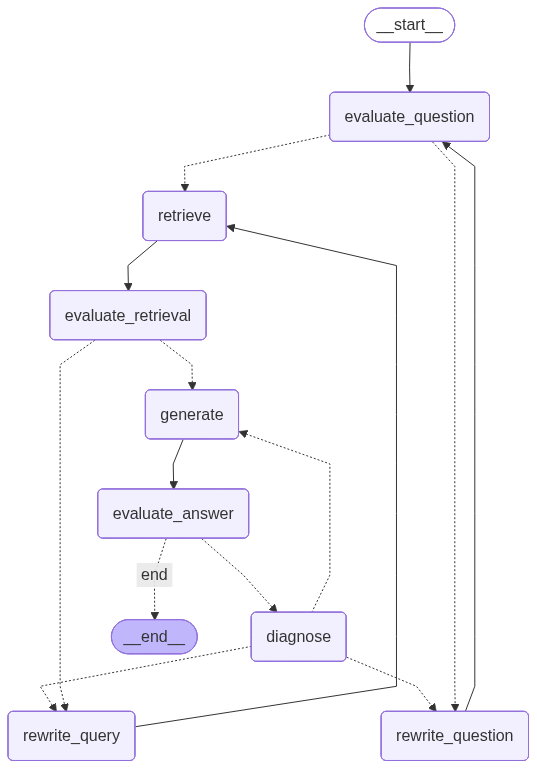

In [19]:
from IPython.display import Image, display

# 그래프 생성
workflow = StateGraph(SelfCorrectingRAGState)

# 노드 추가
workflow.add_node("evaluate_question", evaluate_question)
workflow.add_node("rewrite_question", rewrite_question)
workflow.add_node("retrieve", retrieve_documents)
workflow.add_node("evaluate_retrieval", evaluate_retrieval)
workflow.add_node("rewrite_query", rewrite_search_query)
workflow.add_node("generate", generate_answer)
workflow.add_node("evaluate_answer", evaluate_answer)
workflow.add_node("diagnose", diagnose_problem)

# 시작점 설정
workflow.set_entry_point("evaluate_question")

# 엣지 연결
# 1. 질문 평가 → 조건부 분기
workflow.add_conditional_edges(
    "evaluate_question",
    route_after_question_eval,
    {
        "retrieve": "retrieve",
        "rewrite_question": "rewrite_question"
    }
)

# 2. 질문 재작성 → 다시 평가
workflow.add_edge("rewrite_question", "evaluate_question")

# 3. 검색 → 검색 평가
workflow.add_edge("retrieve", "evaluate_retrieval")

# 4. 검색 평가 → 조건부 분기
workflow.add_conditional_edges(
    "evaluate_retrieval",
    route_after_retrieval_eval,
    {
        "generate": "generate",
        "rewrite_query": "rewrite_query"
    }
)

# 5. 쿼리 재작성 → 다시 검색
workflow.add_edge("rewrite_query", "retrieve")

# 6. 답변 생성 → 답변 평가
workflow.add_edge("generate", "evaluate_answer")

# 7. 답변 평가 → 조건부 분기
workflow.add_conditional_edges(
    "evaluate_answer",
    route_after_answer_eval,
    {
        "end": END,
        "diagnose": "diagnose"
    }
)

# 8. 문제 진단 → 조건부 분기 (해당 단계로 복귀)
workflow.add_conditional_edges(
    "diagnose",
    route_after_diagnosis,
    {
        "rewrite_question": "rewrite_question",
        "rewrite_query": "rewrite_query",
        "generate": "generate"
    }
)

# 컴파일
app = workflow.compile()

print("✅ Self-Correcting RAG 그래프 구성 완료!")

display(Image(app.get_graph().draw_mermaid_png()))

#### 워크플로우 구조:

```
[시작]
  ↓
[질문 평가] → bad? → [질문 재작성] → [질문 평가]
  ↓ good
[문서 검색]
  ↓
[검색 평가] → irrelevant? → [쿼리 재작성] → [문서 검색]
  ↓ relevant
[답변 생성]
  ↓
[답변 평가] → bad? → [문제 진단] → question? → [질문 재작성]
  ↓ good              ↓              retrieval? → [쿼리 재작성]
[종료]                                generation? → [답변 생성]
```

## 7. 실행 및 테스트

### 헬퍼 함수

In [17]:
def ask_with_self_correction(question: str, max_retries: int = 2):
    """Self-Correcting RAG로 질문에 답변"""
    print("\n" + "="*80)
    print(f"💭 원본 질문: {question}")
    print("="*80 + "\n")
    
    initial_state = {
        "original_question": question,
        "current_question": question,
        "question_quality": "",
        "question_rewrite_count": 0,
        "search_query": "",
        "retrieved_docs": [],
        "retrieval_quality": "",
        "search_retry_count": 0,
        "answer": "",
        "answer_quality": "",
        "problem_diagnosis": "",
        "max_retries": max_retries
    }
    
    # 실행
    result = app.invoke(initial_state)
    
    print("\n" + "="*80)
    print(f"✨ 최종 답변:")
    print(f"{result['answer']}")
    print("="*80)
    print(f"\n📊 통계:")
    print(f"  - 질문 재작성 횟수: {result['question_rewrite_count']}")
    print(f"  - 검색 재시도 횟수: {result['search_retry_count']}")
    print(f"  - 최종 질문: {result['current_question']}")
    
    return result

In [18]:
ask_with_self_correction("테크노바의 근무시간은 어떻게 돼?")


💭 원본 질문: 테크노바의 근무시간은 어떻게 돼?

🔍 [질문 평가] 테크노바의 근무시간은 어떻게 돼?
   결과: good
📚 [문서 검색] 쿼리: 테크노바의 근무시간은 어떻게 돼?
   검색된 문서 수: 0
✅ [검색 평가] 결과: relevant
💬 [답변 생성] 완료
⭐ [답변 평가] 결과: good

✨ 최종 답변:
테크노바의 근무시간은 일반적으로 주 5일, 하루 8시간 근무입니다. 보통 오전 9시부터 오후 6시까지 운영되며, 점심시간은 12시부터 1시까지입니다. 하지만 부서나 팀에 따라 다소 차이가 있을 수 있으니, 구체적인 근무시간은 소속 부서의 안내를 참고하시기 바랍니다. 추가 질문이 있으시면 언제든지 말씀해 주세요!

📊 통계:
  - 질문 재작성 횟수: 0
  - 검색 재시도 횟수: 0
  - 최종 질문: 테크노바의 근무시간은 어떻게 돼?


{'original_question': '테크노바의 근무시간은 어떻게 돼?',
 'current_question': '테크노바의 근무시간은 어떻게 돼?',
 'question_quality': 'good',
 'question_rewrite_count': 0,
 'search_query': '테크노바의 근무시간은 어떻게 돼?',
 'retrieved_docs': [],
 'retrieval_quality': 'relevant',
 'search_retry_count': 0,
 'answer': '테크노바의 근무시간은 일반적으로 주 5일, 하루 8시간 근무입니다. 보통 오전 9시부터 오후 6시까지 운영되며, 점심시간은 12시부터 1시까지입니다. 하지만 부서나 팀에 따라 다소 차이가 있을 수 있으니, 구체적인 근무시간은 소속 부서의 안내를 참고하시기 바랍니다. 추가 질문이 있으시면 언제든지 말씀해 주세요!',
 'answer_quality': 'good',
 'problem_diagnosis': '',
 'max_retries': 2}